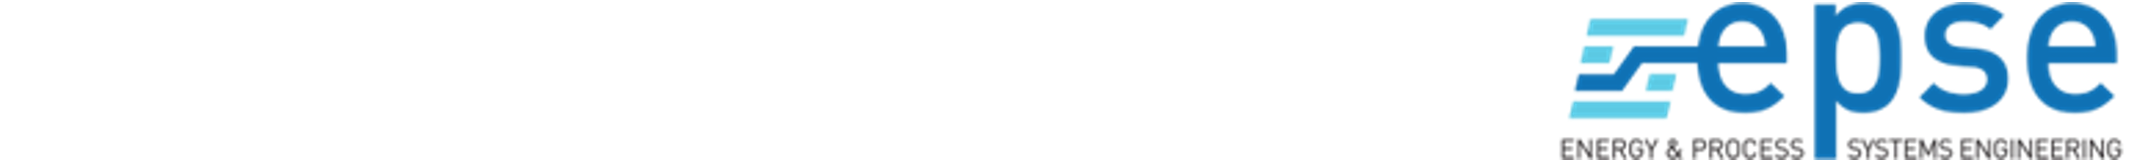

# <center>  Heat Pump Design </center> 

In [3]:
from pylab import *
import Fluid_CP as FCP #calculation of  thermodynamic states
import plotDiag_Th_Ts as Diag #plot Th diagram with heat sink and heat source
from scipy.optimize import  minimize,NonlinearConstraint #optimization
import Compressormodel_SP as CM
import CoolProp.CoolProp as CP

First, we define given parameters.

In [4]:
nominal_Q = 3.5

#refrigerant
delta_T_sh=10. #K #superheating --> assumption
delta_T_sc=5 #K #subcooling --> assumption
fluid="Isobutane"# ---> must be varied 
Eh="CBar"

#source
fluid_so="air"
T_so_in=20. #°C
T_so_out= T_so_in #°C -> parallel flow, same temperature in and out 

#sink
fluid_si="water"
T_si_in=87 #°C
T_si_out=87 #°C -> to be determined for every timestep

#heat exchanger
min_pinch=0.5 #K -> assumption

tube_diameter = 6.38
_D = 35 ##[35,40,45,50] #possible compressor sizes in mm


h_refVapLiq = 2000 #W/m^2/K
h_refVap = 200 #W/m^2/K
h_refLiq = 1000 #W/m^2/K

stainless_lambda_steel = 15 #W/m/K

d_i = 0.00635 #m
d_out = 0.0055 #m
h_water = 1000 #W/m^2/K
d_w = 0.00635 - 0.0055 #m

max_length_condenser = 60 #m


### Isentropic efficiency and refrigerant massflow are calculated through the given Compressor function

In [5]:
def calc_eta(param_calc):
    etas_fun = CM.recip_comp_SP(param_calc,fluid)
    eta_is = etas_fun[0]  # extract isentropic efficiency
    return eta_is

def calc_mdot(param_calc):
    etas_fun = CM.recip_comp_SP(param_calc,fluid)
    m_dot = etas_fun[1]  # extract mass flow rate
    return m_dot

### Create Heat pump process


In [6]:
def HP(param):
    
    T_co, T_ev = param

    # Thermodynamic states of the heat pump process
    # State 1*: evaporator: T1 = T_ev and x1 = 1.0 (saturated vapor)
    param_calc = T_ev, T_co, delta_T_sh, None, _D
    
    eta_is = calc_eta(param_calc)
    m_dot = calc_mdot(param_calc)


    # State 1*: saturated vapor at evaporator pressure
    state1_sat = FCP.state(["T", "x"], [T_ev, 1.0], fluid, Eh)

    # State 1: outlet evaporator, superheated vapor if delta_T_sh > 0
    if delta_T_sh > 0.0:
        state1 = FCP.state(["T", "p"], [T_ev + delta_T_sh, state1_sat["p"]], fluid, Eh)
    else:
        state1 = state1_sat

    # State 3*: saturated liquid at condenser outlet temperature
    state3_sat = FCP.state(["T", "x"], [T_co, 0.0], fluid, Eh)

    # State 3: subcooled liquid at condenser outlet
    state3 = FCP.state(["T", "p"], [T_co - delta_T_sc, state3_sat["p"]], fluid, Eh)

    # State 3x: dewpoint at condenser pressure (x = 1)
    state3x = FCP.state(["T", "x"], [T_co, 1.0], fluid, Eh)

    # State 2s: ideal isentropic compression (s2s = s1, p2s = p3)
    state2s = FCP.state(["p", "s"], [state3["p"], state1["s"]], fluid, Eh)

    # h2 from compressor efficiency
    h2 = state1["h"] + (state2s["h"] - state1["h"]) / eta_is

    # State 2: actual compressor outlet
    state2 = FCP.state(["p", "h"], [state3["p"], h2], fluid, Eh)

    # State 4: after expansion valve (isenthalpic), p4 = p1, h4 = h3
    state4 = FCP.state(["p", "h"], [state1["p"], state3["h"]], fluid, Eh)

    

    return {
        "state1_sat": state1_sat,
        "state1": state1,
        "state2s": state2s,
        "state2": state2,
        "state3_sat": state3_sat,
        "state3": state3,
        "state3x": state3x,
        "state4": state4,
        "h2": h2,
        "eta_is": eta_is,
        "m_dot": m_dot
    }

## COP function
We define a function that returns the reciprocal value of the coefficient of performance (*COP*). This function is called *calc_COP* and reads the variable parameter *param=[T_co,T_ev]*, a vector of the evaporation temperature *T_co* and the condensation temperature *T_ev*, as input parameters. The optimizer *minimize* requires that all optimization variables are passed in a vector. 

In [7]:
def calc_COP(param): #--> include the COP_rev here...

    T_co, T_ev = param
    
    hp_vals = HP(param)

    state1 = hp_vals["state1"]

    state3= hp_vals["state3"]

    state2= hp_vals["state2"]

    #spec. heat released in the condenser
    q_high=state2["h"]-state3["h"] #kJ/kg
    #spec. compressor work
    w_comp=state2["h"]-state1["h"]  #kJ/kg
    #coefficient of performance 

    COP=q_high/w_comp
    #return reciprocal value of COP
    return 1./COP

## Pinch Points

### Pinch points evaporator (in- or outlet)

In [8]:
def pinch_evap(param):

    T_co, T_ev = param
    
    hp_vals = HP(param)
    
    ##### Evaporator outlet
    #The temperature difference at the outlet of the evaporator *delta_T_out_ev* is the difference 
    #between the inlet temperature of the source *T_so_in* and the outlet temperature of the refrigerant *T_1*.

    state1 = hp_vals["state1"]

    state4 = hp_vals["state4"]

    delta_T_out_ev=T_so_in-state1["T"]
    
    ##### Evaporator inlet
    #The temperature difference at the inlet of the evaporator *delta_T_in_ev* is the difference 
    #between the outlet temperature of the source *T_so_out* and the inlet temperature of the refrigerant *T_4*. 
    delta_T_in_ev=T_so_out-state4["T"]
    
    #return the values at inlet and outlet as a vector
    return [delta_T_in_ev,delta_T_out_ev]

### Pinch points condenser (in- , outlet or dew line refrigerant)

In [9]:
def pinch_con(param):
    
    T_co, Tev = param

    hp_vals = HP(param)

    state3 = hp_vals["state3"]

    state2 = hp_vals["state2"]

    state3x = hp_vals["state3x"]
    
    ##### Condenser outlet 
    #The temperature difference at the outlet of the condenser *delta_T_out_co* is the difference 
    #between the outlet temperature of the refrigerant *T_3* and the inlet temperature of the sink *T_si_in*.
    delta_T_out_co=state3["T"]-T_si_in

    ##### Condenser inlet
    #The temperature difference at the inlet of the condenser *delta_T_in_co* is the difference 
    #between the inlet temperature of the refrigerant *T_2* and the outlet temperature of the sink *T_si_out*.
    delta_T_in_co=state2["T"]-T_si_out
    
    ##### Dew line condenser (refrigerant)
    #The temperature difference at the inside of the condenser *delta_T_inside_co* is the difference between the condenser
    #temperature *T_con* and the temperature of the heat sink at the dew line of the refrigerant *T_si_inside*.
    
    #enthalpy of the refrigerant at the inlet/outlet of the condenser
    h_out_co=state3["h"]
    h_in_co=state2["h"]
    
    #enthalpy of saturated vapor at T_co and p_co: h_sat_Tco
    h_sat_Tco=state3x["h"]

    #Enthalpies of heat sink 
    h_si_in=FCP.state(["T","p"],[T_si_in,1.0],fluid_si,Eh)["h"]
    h_si_out=FCP.state(["T","p"],[T_si_out,1.0],fluid_si,Eh)["h"]

    #State of the heat sink at the point the refrigerant passes the dew line
    h_si_inside=h_si_out-(h_si_out-h_si_in)/(state2["h"]-state3["h"])*(state2["h"]-h_sat_Tco)
    T_si_inside=FCP.state(["p","h"],[1.0,h_si_inside],fluid_si,Eh)["T"]
    #temperature difference
    delta_T_inside_co=T_co-T_si_inside
    
    #return the values at inlet, outlet, and dew line as a vector
    return [delta_T_in_co,delta_T_out_co,delta_T_inside_co]


## Condenser Length

### R_L_evap and R_L_sh

In [10]:
#thermal resistance times tube length for convective heat transfer
def calc_RL_conv(h_transfer,d_tube_inner):
    R_L_conv=1./(h_transfer*pi*d_tube_inner) #mK/W
    return R_L_conv

#thermal resistance times tube length for conductive heat transfer
def calc_RL_cond(lambda_w,d_w,d_out,d_i):
    R_L_cond= d_w/(lambda_w*((d_out-d_i)/(log(d_out/d_i)))*pi) #mK/W
    return R_L_cond


In [11]:
#convective heat transfer inner tube wall
R_L_h_refVap = calc_RL_conv(h_refVap,d_i)
#conductive heat transfer through wall
R_L_lambda_w=calc_RL_cond(stainless_lambda_steel,d_w,d_out,d_i)
#convective heat transfer outer tube wall
R_L_h_water=calc_RL_conv(h_water,d_out)

R_L_sh=R_L_h_refVap+R_L_lambda_w+R_L_h_water
print("thermal resistance per meter during condensation in superheated state=",round(R_L_sh,4),"mK/W")

#convective heat transfer inner tube wall
R_L_h_reflat=calc_RL_conv(h_refVapLiq,d_i)

R_L_lat=R_L_h_reflat+R_L_lambda_w+R_L_h_water
print("thermal resistance per meter during latent=",round(R_L_lat,4),"mK/W")

#convective heat transfer inner tube wall
R_L_h_refLiq=calc_RL_conv(h_refLiq,d_i)

R_L_sc=R_L_h_refLiq+R_L_lambda_w+R_L_h_water
print("thermal resistance per meter during subcooling=",round(R_L_sc,4),"mK/W")

thermal resistance per meter during condensation in superheated state= 0.3116 mK/W
thermal resistance per meter during latent= 0.086 mK/W
thermal resistance per meter during subcooling= 0.1111 mK/W


In [12]:
def calc_spec_length(param):

    T_co,T_ev =param

    hp_vals = HP(param)

    state2 = hp_vals["state2"]

    state3 = hp_vals["state3"]

    state3_sat = hp_vals["state3_sat"]

    state3x = hp_vals["state3x"]

    h2 = hp_vals["h2"]

    m_dot = hp_vals["m_dot"]
    
    #heat flow condenser
    Q_con_sh = m_dot*(h2-state3x['h']) #kW
    Q_con_lat =m_dot*(state3x["h"]-state3_sat["h"]) #kW
    Q_con_sc = m_dot*(state3_sat['h'] - state3['h'])

    print("Heat for condensing superheat=",round(Q_con_sh,2),"kW")
    print("Heat for condensing latent=",round(Q_con_lat,2),"kW")
    print("Heat for condensing subcooling=",round(Q_con_sc,2),"kW")
    print("Heat in= ",round(Q_con_sh+Q_con_lat+Q_con_sc,2),"kW")
    
    T3sat = state3_sat['T']
    T3x = state3x['T']
    T2 = state2['T']
    #temperarture of air=constant 
    eps = 1e-20 #to avoid division by zero in logarithm
    T_water_worst_case = T_si_in - eps #T_si_in #can be adjusted, depends on the heatpump design and controlling 
    
    #logarithmic mean temperature difference during condensing, all steps 
    deltaT_m_sc=((T3sat - T_si_in) - ((T3sat - delta_T_sc)- T_si_in))/(log((T3sat - T_si_in)/((T3sat - delta_T_sc) - T_si_in )))
    deltaT_m_sh=((T2 - T_water_worst_case) - (T3x - T_water_worst_case))/(log((T2 - T_water_worst_case)/(T3x - T_water_worst_case)))

    L_con_sc = Q_con_sc*1000*R_L_sc/(deltaT_m_sc)
    L_con_lat = Q_con_lat*1000*R_L_lat/(T3sat - T_water_worst_case)
    L_con_sh = Q_con_sh*1000*R_L_sh/(deltaT_m_sh)
    
    print("Tube length for condensing superheating= ",round(L_con_sh,2),"m")
    print("Tube length for condensing latent= ",round(L_con_lat,2),"m")
    print("Tube length for condensing subcooling= ",round(L_con_sc,2),"m")
    L_t=L_con_sc+L_con_lat+L_con_sh
    print("Total length of condenser tube=",round(L_t,2),"m")
    return L_t, Q_con_sh + Q_con_lat + Q_con_sc

In [13]:
def tot_heat(x):
    _, Q_out = calc_spec_length(x)  # or however you compute total Q
    return Q_out


## Optimization
As we want to optimize the heat pump process regarding the COP, *calc_COP* is the objective function (function to be optimized). Since optimizers always minimize a function the return value of the function *calc_COP* is the reciprocal of COP (1/COP). 

In [ ]:
#Syntax: bounds=[(T_co_min, T_co_max), (T_ev_min, T_ev_max)]
#Define appropriate bounds
bounds=[(T_si_in,np.inf),(-np.inf,T_so_in)] #(T_co_min, T_co_max), (T_ev_min, T_ev_max)


#For a function funct with three return values, nonlinear constraints are defined as follows:
#Syntax: NC1=NonlinearConstraint(func, [min_1,min_2,min_3],[max_1,max_2, max_3])
#Define the nonlinear constaints for the approach temperatures: NC1, NC2
NC1=NonlinearConstraint(pinch_evap, [min_pinch,min_pinch],[np.inf,np.inf])
NC2=NonlinearConstraint(pinch_con, [min_pinch,min_pinch,min_pinch],[np.inf,np.inf,np.inf])
NC3a=NonlinearConstraint(lambda x: [calc_spec_length(x)[0]], [0], [max_length_condenser])
NC3b=NonlinearConstraint(lambda x: [calc_spec_length(x)[1]], [nominal_Q], [nominal_Q])


#Syntax:  NCs=(NC1, NC2,....)
NCs=[NC1,NC2,NC3a,NC3b]

#Define an appropriate initial guess (starting point).
T_co_start = T_si_in + 10 #°C
T_ev_start = T_so_in - 10 #°C
#Use minimize to optimize the COP
Opti=minimize(calc_COP,x0=[T_co_start, T_ev_start],method='SLSQP',bounds=bounds,constraints=NCs)
#Check if the optimization terminated successfull and print the COP
print("Success optimization=",Opti.success)
COP=1./calc_COP(Opti.x)
print("optimized COP = ",round(COP,2))
#Print the optimized evaporator and condenser temperature: T_ev_op, T_co_op
T_ev_op=Opti.x[1]
T_co_op=Opti.x[0]
print("optimized condensation temperature= ",round(T_co_op,2),"°C")
print("optimized evaporation temperature= ",round(T_ev_op,2),"°C")

Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.89 kW
Heat for condensing subcooling= 0.21 kW
Heat in=  3.73 kW
Tube length for condensing superheating=  11.23 m
Tube length for condensing latent=  24.84 m
Tube length for condensing subcooling=  3.26 m
Total length of condenser tube= 39.32 m
Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.89 kW
Heat for condensing subcooling= 0.21 kW
Heat in=  3.73 kW
Tube length for condensing superheating=  11.23 m
Tube length for condensing latent=  24.84 m
Tube length for condensing subcooling=  3.26 m
Total length of condenser tube= 39.32 m
Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.89 kW
Heat for condensing subcooling= 0.21 kW
Heat in=  3.73 kW
Tube length for condensing superheating=  11.23 m
Tube length for condensing latent=  24.84 m
Tube length for condensing subcooling=  3.26 m
Total length of condenser tube= 39.32 m
Heat for condensing superheat= 0.63 kW
Heat for condensing

### Post-processing 
We calculate the thermodynamic states of the optimized heat pump process.

In [ ]:
#thermodynamic states of the heat pump process as a function of the optimal evaporation and condensation temperatures
#state1_sat_op: evaporator: T1=T_ev_op and x1=1.0 (saturated vapor)

hp_evals = HP((T_co_op,T_ev_op))

state1_sat_op=hp_evals["state1_sat"]

#state1_op: outlet evaporator: T1=T_ev_op+delta_T_sh and p1=p1_sat
state1_op = hp_evals["state1"]

#state3_sat_op: outlet condenser: T3=T_co_op and x3=0.0 (boiling liquid)
state3_sat_op= hp_evals["state3_sat"]
#state3_op: outlet condenser: T3=T_co_op-delta_T_sc and p3=p3_stat
state3_op= hp_evals["state3"]
# State 3x: dewpoint at condenser pressure (x = 1)

state3x_op = hp_evals["state3x"]

eta_is = hp_evals["eta_is"]
m_dot = hp_evals["m_dot"]

#state2s_op: isentropic compressor: p2s=p_co=p3 and s2s=s1 
state2s_op= hp_evals["state2s"]
#enthalpy h2 is calulated using the compressor efficiency eta_is
h2_op= hp_evals["h2"]
#state2_op: outlet compressor: p2=p_co=p3 and h2
state2_op= hp_evals["state2"]
#state4_op: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
state4_op= hp_evals["state4"]

Q_con_sh = m_dot*(h2_op-state3x_op['h']) #kW
Q_con_lat =m_dot*(state3x_op["h"]-state3_sat_op["h"]) #kW
Q_con_sc = m_dot*(state3_sat_op['h'] - state3_op['h'])

print("Heat for condensing superheat=",round(Q_con_sh,2),"kW")
print("Heat for condensing latent=",round(Q_con_lat,2),"kW")
print("Heat for condensing subcooling=",round(Q_con_sc,2),"kW")
print("Heat in= ",round(Q_con_sh+Q_con_lat+Q_con_sc,2),"kW")

T3sat = state3_sat_op['T']
T3x = state3x_op['T']
T2 = state2_op['T']
#temperarture of air=constant 
T_water_worst_case = T_si_in #can be adjusted, depends on the heatpump design and controlling 


#logarithmic mean temperature difference during condensing, all steps 
#deltaT_m_sc=(((T3sat - delta_T_sc)- T_water_worst_case) - (T3sat - T_water_worst_case))/(log(((T3sat - delta_T_sc) - T_water_worst_case )/(T3sat - T_water_worst_case)))
#eltaT_m_sh=((T3x - T_water_worst_case) - (T2 - T_water_worst_case))/(log((T3x - T_water_worst_case)/(T2 - T_water_worst_case))) 

#deltaT_m_sc=((T3sat - T_water_worst_case) - ((T3sat - delta_T_sc)- T_water_worst_case))/(log((T3sat - T_water_worst_case)/((T3sat - delta_T_sc) - T_water_worst_case )))
#deltaT_m_sh=((T2 - T_water_worst_case) - (T3x - T_water_worst_case))/(log((T2 - T_water_worst_case)/(T3x - T_water_worst_case))) 

#deltaT_m_sc=((delta_T_sc + min_pinch - min_pinch)/log((delta_T_sc + min_pinch)/min_pinch))
deltaT_m_sc=((T3sat - T_water_worst_case) - ((T3sat - delta_T_sc)- T_water_worst_case))/(log((T3sat - T_water_worst_case)/((T3sat - delta_T_sc) - T_water_worst_case )))
deltaT_m_sh=((T2 - T_water_worst_case) - (T3x - T_water_worst_case))/(log((T2 - T_water_worst_case)/(T3x - T_water_worst_case))) 

L_con_sc = Q_con_sc*1000*R_L_sc/(deltaT_m_sc)
L_con_lat = Q_con_lat*1000*R_L_lat/(T3sat - T_water_worst_case)
L_con_sh = Q_con_sh*1000*R_L_sh/(deltaT_m_sh)

print("Tube length for condensing superheating= ",round(L_con_sh,2),"m")
print("Tube length for condensing latent= ",round(L_con_lat,2),"m")
print("Tube length for condensing subcooling= ",round(L_con_sc,2),"m")
L_t=L_con_sc+L_con_lat+L_con_sh
print("Total length of condenser tube=",round(L_t,2),"m")
print("optimized condensation temperature= ",round(T_co_op,2),"°C")
print("optimized evaporation temperature= ",round(T_ev_op,2),"°C")

Heat for condensing superheat= 0.62 kW
Heat for condensing latent= 2.67 kW
Heat for condensing subcooling= 0.2 kW
Heat in=  3.5 kW
Tube length for condensing superheating=  14.67 m
Tube length for condensing latent=  37.63 m
Tube length for condensing subcooling=  7.7 m
Total length of condenser tube= 60.0 m
optimized condensation temperature=  99.11 °C
optimized evaporation temperature=  9.25 °C


Further, we create a Th diagram using the *Th* function from *plotDiag_Th_Ts.py*.

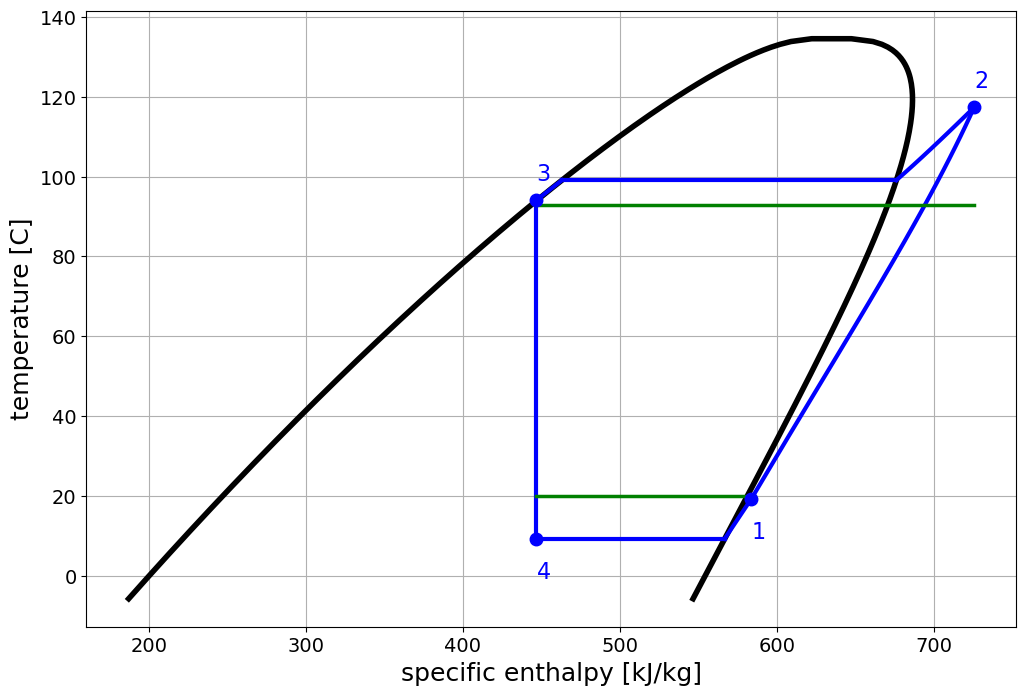

In [184]:
Diag.Th(state1_op,state2_op,state3_op,state4_op,[T_si_in,T_si_out],[T_so_in,T_so_out],fluid,Eh)

The pinch points in the evaporator and the condenser are calculated with the functions *pinch_evap* and *pinch_con*.

In [203]:
#evaporator
delta_T_pinch_ev=pinch_evap([T_co_op,T_ev_op])
print("Pinch evaporator (optimized): delta_T_pinch_v=",round(min(delta_T_pinch_ev[0],delta_T_pinch_ev[1]),4),"K")
print(delta_T_pinch_ev)
#condenser
delta_T_pinch_co=pinch_con([T_co_op,T_ev_op])
print(delta_T_pinch_co)
print("Pinch condenser (optimized): delta_T_pinch_c=",round(min(delta_T_pinch_co[0],delta_T_pinch_co[1],delta_T_pinch_co[2]),4),"K")

Pinch evaporator (optimized): delta_T_pinch_v= 0.7538 K
[np.float64(10.753770873836572), np.float64(0.7537708738284437)]
[np.float64(24.363431145962068), np.float64(1.1125568834705746), np.float64(6.112556883469523)]
Pinch condenser (optimized): delta_T_pinch_c= 1.1126 K


## Checking COP's for different power levels / refrigerants / compressor sizes

In [32]:
maxQ = 4
minQ = 3

nominal_Q = 3

delta_T_sh=10. #K #superheating --> assumption
delta_T_sc=5 #K #subcooling --> assumption
fluids = ["Isobutane","Butane","Isobutene","DimethylEther"]
Eh="CBar"

#source
fluid_so="air"
T_so_in=20. #°C
T_so_out= T_so_in #°C -> parallel flow, same temperature in and out 

#sink
fluid_si="water"
T_si_in=87 #°C
T_si_out=87 #°C -> to be determined for every timestep

#heat exchanger
min_pinch=0.5 #K -> assumption

tube_diameter = 6.38
_Ds = [35,40,45,50] #possible compressor sizes in mm


In [41]:
import pandas as pd

worst_case = pd.read_csv("controlling_temperature_off_for_fixed_Q.csv")

worst_case_dict = dict(zip(worst_case.iloc[:, 0], worst_case.iloc[:, 1]))

worst_case_dict = {k: v for k, v in worst_case_dict.items() if pd.notna(v)}

worst_case_dict

{3.0: 89.0295029164703,
 3.1: 89.21620654347248,
 3.2: 89.34496670846283,
 3.3: 89.52923882132097,
 3.4: 89.57545641213352,
 3.5: 89.70487954794233,
 3.6: 89.72465972649731}

In [42]:
## Running optimization

# sink temperature defined at the start of the notebook

# reminder the length constraint is set to 60 m for the condenser

COPs = dict()

for i in list(worst_case_dict.keys()):

    T_si_in=worst_case_dict[i]
    T_si_out=T_si_in

    _D = 35

    bounds=[(T_si_in,np.inf),(-np.inf,T_so_in)]

    NC1=NonlinearConstraint(pinch_evap, [min_pinch,min_pinch],[np.inf,np.inf])
    NC2=NonlinearConstraint(pinch_con, [min_pinch,min_pinch,min_pinch],[np.inf,np.inf,np.inf])
    NC3a = NonlinearConstraint(lambda x: [calc_spec_length(x)[0]], [0], [max_length_condenser])
    NC3b = NonlinearConstraint(lambda x: [calc_spec_length(x)[1]], [i], [i])


    #Syntax:  NCs=(NC1, NC2,....)
    NCs=[NC1,NC2,NC3a,NC3b]

    #Define an appropriate initial guess (starting point).
    T_co_start = T_si_in + 10 #°C
    T_ev_start = T_so_in - 10 #°C
    #Use minimize to optimize the COP
    Opti=minimize(calc_COP,x0=[T_co_start, T_ev_start],method='SLSQP',bounds=bounds,constraints=NCs)
    #Check if the optimization terminated successfull and print the COP
    print("Success optimization=",Opti.success)
    COP=1./calc_COP(Opti.x)
    print("optimized COP = ",round(COP,2))
    #Print the optimized evaporator and condenser temperature: T_ev_op, T_co_op
    T_ev_op=Opti.x[1]
    T_co_op=Opti.x[0]
    print("optimized condensation temperature= ",round(T_co_op,2),"°C")
    print("optimized evaporation temperature= ",round(T_ev_op,2),"°C")

    if Opti.success:
        COPs[round(float(i),2)] = round(float(COP),2)
    else:
        print("requried constraints not achieved")

COPs

Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.78 kW
Heat for condensing subcooling= 0.21 kW
Heat in=  3.62 kW
Tube length for condensing superheating=  11.25 m
Tube length for condensing latent=  23.87 m
Tube length for condensing subcooling=  3.24 m
Total length of condenser tube= 38.37 m
Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.78 kW
Heat for condensing subcooling= 0.21 kW
Heat in=  3.62 kW
Tube length for condensing superheating=  11.25 m
Tube length for condensing latent=  23.87 m
Tube length for condensing subcooling=  3.24 m
Total length of condenser tube= 38.37 m
Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.78 kW
Heat for condensing subcooling= 0.21 kW
Heat in=  3.62 kW
Tube length for condensing superheating=  11.25 m
Tube length for condensing latent=  23.87 m
Tube length for condensing subcooling=  3.24 m
Total length of condenser tube= 38.37 m
Heat for condensing superheat= 0.63 kW
Heat for condensing

{3.0: 1.94, 3.1: 1.96, 3.2: 1.98, 3.3: 2.0, 3.4: 2.02, 3.5: 2.03, 3.6: 2.05}

In [ ]:
COPs = dict()

for i in fluids:

    _D = 35

    fluid = i

    bounds=[(T_si_in,np.inf),(-np.inf,T_so_in)]

    NC1=NonlinearConstraint(pinch_evap, [min_pinch,min_pinch],[np.inf,np.inf])
    NC2=NonlinearConstraint(pinch_con, [min_pinch,min_pinch,min_pinch],[np.inf,np.inf,np.inf])
    NC3a = NonlinearConstraint(lambda x: [calc_spec_length(x)[0]], [0], [max_length_condenser])
    NC3b = NonlinearConstraint(lambda x: [calc_spec_length(x)[1]], [nominal_Q], [nominal_Q])


    #Syntax:  NCs=(NC1, NC2,....)
    NCs=[NC1,NC2,NC3a,NC3b]

    #Define an appropriate initial guess (starting point).
    T_co_start = T_si_in + 10 #°C
    T_ev_start = T_so_in - 10 #°C
    #Use minimize to optimize the COP
    Opti=minimize(calc_COP,x0=[T_co_start, T_ev_start],method='SLSQP',bounds=bounds,constraints=NCs)
    #Check if the optimization terminated successfull and print the COP
    print("Success optimization=",Opti.success)
    COP=1./calc_COP(Opti.x)
    print("optimized COP = ",round(COP,2))
    #Print the optimized evaporator and condenser temperature: T_ev_op, T_co_op
    T_ev_op=Opti.x[1]
    T_co_op=Opti.x[0]
    print("optimized condensation temperature= ",round(T_co_op,2),"°C")
    print("optimized evaporation temperature= ",round(T_ev_op,2),"°C")

    if Opti.success:
        COPs[i] = round(float(COP),2)
    else:
        print("requried constraints not achieved")

COPs


Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.89 kW
Heat for condensing subcooling= 0.21 kW
Heat in=  3.73 kW
Tube length for condensing superheating=  11.23 m
Tube length for condensing latent=  24.84 m
Tube length for condensing subcooling=  3.26 m
Total length of condenser tube= 39.32 m
Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.89 kW
Heat for condensing subcooling= 0.21 kW
Heat in=  3.73 kW
Tube length for condensing superheating=  11.23 m
Tube length for condensing latent=  24.84 m
Tube length for condensing subcooling=  3.26 m
Total length of condenser tube= 39.32 m
Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.89 kW
Heat for condensing subcooling= 0.21 kW
Heat in=  3.73 kW
Tube length for condensing superheating=  11.23 m
Tube length for condensing latent=  24.84 m
Tube length for condensing subcooling=  3.26 m
Total length of condenser tube= 39.32 m
Heat for condensing superheat= 0.63 kW
Heat for condensing

KeyboardInterrupt: 

In [236]:
COPs = dict()

for i in _Ds:

    fluid = "Isobutane"
    
    _D = i

    bounds=[(T_si_in,np.inf),(-np.inf,T_so_in)]

    NC1=NonlinearConstraint(pinch_evap, [min_pinch,min_pinch],[np.inf,np.inf])
    NC2=NonlinearConstraint(pinch_con, [min_pinch,min_pinch,min_pinch],[np.inf,np.inf,np.inf])
    NC3a = NonlinearConstraint(lambda x: [calc_spec_length(x)[0]], [0], [max_length_condenser])
    NC3b = NonlinearConstraint(lambda x: [calc_spec_length(x)[1]], [nominal_Q], [nominal_Q])


    #Syntax:  NCs=(NC1, NC2,....)
    NCs=[NC1,NC2,NC3a,NC3b]

    #Define an appropriate initial guess (starting point).
    T_co_start = T_si_in + 10 #°C
    T_ev_start = T_so_in - 10 #°C
    #Use minimize to optimize the COP
    Opti=minimize(calc_COP,x0=[T_co_start, T_ev_start],method='SLSQP',bounds=bounds,constraints=NCs)
    #Check if the optimization terminated successfull and print the COP
    print("Success optimization=",Opti.success)
    COP=1./calc_COP(Opti.x)
    print("optimized COP = ",round(COP,2))
    #Print the optimized evaporator and condenser temperature: T_ev_op, T_co_op
    T_ev_op=Opti.x[1]
    T_co_op=Opti.x[0]
    print("optimized condensation temperature= ",round(T_co_op,2),"°C")
    print("optimized evaporation temperature= ",round(T_ev_op,2),"°C")

    if Opti.success:
        COPs[i] = round(float(COP),2)
    else:
        print("requried constraints not achieved")

COPs

Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.89 kW
Heat for condensing subcooling= 0.21 kW
Heat in=  3.73 kW
Tube length for condensing superheating=  11.23 m
Tube length for condensing latent=  24.84 m
Tube length for condensing subcooling=  3.26 m
Total length of condenser tube= 39.32 m
Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.89 kW
Heat for condensing subcooling= 0.21 kW
Heat in=  3.73 kW
Tube length for condensing superheating=  11.23 m
Tube length for condensing latent=  24.84 m
Tube length for condensing subcooling=  3.26 m
Total length of condenser tube= 39.32 m
Heat for condensing superheat= 0.63 kW
Heat for condensing latent= 2.89 kW
Heat for condensing subcooling= 0.21 kW
Heat in=  3.73 kW
Tube length for condensing superheating=  11.23 m
Tube length for condensing latent=  24.84 m
Tube length for condensing subcooling=  3.26 m
Total length of condenser tube= 39.32 m
Heat for condensing superheat= 0.63 kW
Heat for condensing

{35: 1.98, 40: 1.8, 45: 1.66, 50: 1.54}